In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


setup sessão spark (grande volume de dados)

In [10]:
# instalar as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [12]:
import findspark
findspark.init()

In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("ChurnCase") \
    .getOrCreate()

In [ ]:
import kagglehub
import os
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Importação de Dados


Origem dados: Kaggle - importação via kaggle


In [15]:
# baixar dados da pasta do data master
path = kagglehub.dataset_download("gcenachi/case-data-master-2024")

print("Path to dataset files:", path)

100%|██████████| 3.96G/3.96G [00:41<00:00, 103MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gcenachi/case-data-master-2024/versions/1


avaliação arquivos disponíveis no diretório Kaggle

In [16]:
# Ver tudo que foi baixado
print("Arquivos encontrados:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

Arquivos encontrados:
/root/.cache/kagglehub/datasets/gcenachi/case-data-master-2024/versions/1/transactions.parquet
/root/.cache/kagglehub/datasets/gcenachi/case-data-master-2024/versions/1/user_logs.parquet
/root/.cache/kagglehub/datasets/gcenachi/case-data-master-2024/versions/1/members.parquet


In [17]:
print("DIretório dos dados: "+path)

DIretório dos dados: /root/.cache/kagglehub/datasets/gcenachi/case-data-master-2024/versions/1


In [18]:
#leitura dos dados
df_transactions = spark.read.parquet(f"{path}/transactions.parquet")
df_members = spark.read.parquet(f"{path}/members.parquet")
df_user_logs = spark.read.parquet(f"{path}/user_logs.parquet")

In [19]:
df_transactions.show(5)
df_members.show(5)
df_user_logs.show(5)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSk...|               38|              410|           1788|              1788|            0|        20151121|              20170104|        0|201511|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150526|              20150626|        0|201505|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150926|              20151026|        0|201509|
|++/9R3sX3

* A base transactions possui informações de registros de pagamentos, valores, datas de transação
* A base member possui informaçoes de registro e demograficas dos clientes
* A base user logs possui informaões de uso da plataforma pelos clientes

Avaliação quantidade de registros por Safra

In [20]:

 df_members.groupBy("safra").count().orderBy("safra").show()


+------+-------+
| safra|  count|
+------+-------+
|201601|4294184|
|201602|4502354|
|201603|4697972|
|201604|4876301|
|201605|5060705|
|201606|5250064|
|201607|5439337|
|201608|5615921|
|201609|5778986|
|201610|5949288|
|201611|6114345|
|201612|6287789|
+------+-------+



In [21]:
df_transactions.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 548792|
|201502| 545303|
|201503| 626488|
|201504| 564582|
|201505| 571552|
|201506| 775737|
|201507| 665280|
|201508| 705975|
|201509| 714610|
|201510| 680465|
|201511| 820345|
|201512| 861107|
|201601| 856716|
|201602| 792300|
|201603| 775469|
|201604| 774169|
|201605| 783956|
|201606| 804729|
|201607| 924032|
|201608| 966450|
|201609| 982640|
|201610|1033898|
|201611|1094941|
|201612| 968547|
|201701| 988576|
|201702| 885566|
+------+-------+



In [22]:
df_user_logs.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 937789|
|201502| 933040|
|201503| 944739|
|201504| 939930|
|201505| 924216|
|201506| 916862|
|201507| 871491|
|201508| 920129|
|201509| 903194|
|201510|1012953|
|201511|1041975|
|201512|1039271|
|201601|1076712|
|201602|1041248|
|201603|1048941|
|201604|1042406|
|201605|1056491|
|201606|1081181|
|201607|1102807|
|201608|1103078|
|201609|1112601|
|201610|1139089|
|201611|1183088|
|201612|1135573|
|201701|1136003|
|201702|1114164|
+------+-------+



In [23]:
df_transactions.count()

20712225

In [24]:
df_members.count()

63867246

In [25]:
df_user_logs.count()

26758971

In [31]:
#avaliação se há duplicatas nos registros por membro dentro de uma mesma safra
print(df_members.filter(F.col("safra") == 201612 ).select("msno").distinct().count())
print(df_members.filter(F.col("safra") == 201612).count())

6287789
6287789


In [27]:
df_user_logs.count()

26758971

A base members possuí registros mensais de todas as safras de 2016. As outras bases possuem registros de 12m antes da primeira safra de members e 3 meses após a última.

#Exploratória

## Base Members

* Volume de clientes por mês (safra)

* Evolução do número de clientes ao longo do tempo

* Distribuição de idade, sexo, país de origem, método de registro

* Clientes novos por mês (is_new se existir ou criar com base no registration_init_time)

* Tempo desde o registro até a safra

In [35]:
df_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)



In [ ]:
#visão geral base
df_members.describe()

### Avaliação de nulos

In [34]:
#contagem de nulos
df_members.select([
    (count(when(col(c).isNull() | isnan(col(c)), c)) / df_members.count()).alias(f"{c}_pct_null")
    for c in df_members.columns
]).show()

+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+
|msno_pct_null|safra_pct_null|registration_init_time_pct_null|city_pct_null|bd_pct_null|   gender_pct_null|registered_via_pct_null|is_ativo_pct_null|
+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+
|          0.0|           0.0|                            0.0|          0.0|        0.0|0.5982750062528138|                    0.0|              0.0|
+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+



A Coluna de genero apresentou grande proporção de nulos. Seráfeita uma analise dessa coluna em relação a taxa de churn para decisão se ela sera utilizada no modelo.

### Volume de registros por mês

In [29]:
from pyspark.sql import functions as F

df_members.groupBy("safra").agg(
    F.count("*").alias("registros"),
    F.countDistinct("msno").alias("ids_unicos")
).orderBy("safra").show()

+------+---------+----------+
| safra|registros|ids_unicos|
+------+---------+----------+
|201601|  4294184|   4294184|
|201602|  4502354|   4502354|
|201603|  4697972|   4697972|
|201604|  4876301|   4876301|
|201605|  5060705|   5060705|
|201606|  5250064|   5250064|
|201607|  5439337|   5439337|
|201608|  5615921|   5615921|
|201609|  5778986|   5778986|
|201610|  5949288|   5949288|
|201611|  6114345|   6114345|
|201612|  6287789|   6287789|
+------+---------+----------+



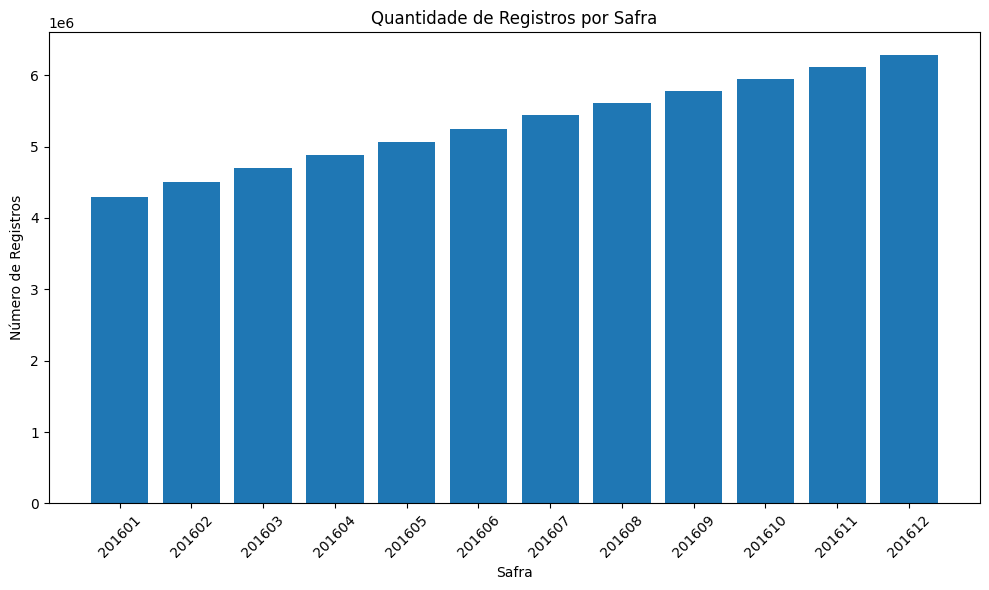

In [30]:

safra_counts_df = df_members.groupBy("safra").count().orderBy("safra").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(safra_counts_df["safra"], safra_counts_df["count"])
plt.xlabel("Safra")
plt.ylabel("Número de Registros")
plt.title("Quantidade de Registros por Safra")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Gênero


In [65]:
df_members.groupBy("gender").count().orderBy("count", ascending=False).show()

+------+--------+
|gender|   count|
+------+--------+
|  null|38210177|
|  male|13075425|
|female|12581644|
+------+--------+



### Idade

In [39]:
df_members.show(5)

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUg...|201612|              20140927|   1|  0|  null|             7|       1|
|++/AwGzubug3gT6J+...|201607|              20150322|   1|  0|  null|             9|       0|
|++/Gw1B9K+XOlB3hL...|201601|              20121217|  15| 32|  male|             3|       1|
|++02XbtviomSxcIBU...|201603|              20131112|  14| 21|  male|             7|       0|
|++0O0Bq04sB/9ZcOS...|201610|              20141021|   5| 33|  male|             3|       0|
+--------------------+------+----------------------+----+---+------+--------------+--------+
only showing top 5 rows



apesar do nome birthday date (bd) a variavel traz uma informação numérica

In [52]:
df_members.select("bd").describe().show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63867246|
|   mean|11.430160210759675|
| stddev|19.041318387984273|
|    min|               -10|
|    max|               994|
+-------+------------------+



In [38]:
total = df_members.count()

# Idade zero ou negativa
qtd_baixa = df_members.filter(col("bd") <= 0).count()
pct_baixa = qtd_baixa / total * 100

# Idade muito alta
qtd_alta = df_members.filter(col("bd") > 100).count()
pct_alta = qtd_alta / total * 100

print(f"Idades ≤ 0: {qtd_baixa} registros ({pct_baixa:.2f}%)")
print(f"Idades > 100: {qtd_alta} registros ({pct_alta:.2f}%)")


Idades ≤ 0: 39512942 registros (61.87%)
Idades > 100: 56654 registros (0.09%)


In [66]:
df_safra = df_members.filter(
    (col("safra") == "201612")
)

# Criar coluna com faixa etária
df_safra = df_safra.withColumn(
    "faixa_etaria",
    when(col("bd") < 0, "abaixo de 0")
    .when(col("bd") == 0, "0")
    .when(col("bd") < 10, "0-9")
    .when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, " 70-79")
    .when(col("bd") < 90, " 80-89")
    .when(col("bd") < 120, " 90-120")
    .otherwise("a partir de 120")
)

df_safra.groupBy("faixa_etaria").count().orderBy("faixa_etaria").show()


+---------------+-------+
|   faixa_etaria|  count|
+---------------+-------+
|          70-79|   3801|
|          80-89|   1400|
|         90-120|   7055|
|              0|4139317|
|            0-9|    895|
|          10-19| 308444|
|          20-29| 950801|
|          30-39| 538022|
|          40-49| 235528|
|          50-59|  81769|
|          60-69|  20116|
|a partir de 120|    368|
|    abaixo de 0|    273|
+---------------+-------+



Existe um percentual alto de zeros assim como alguns casos negativos, menores de idade e idades muito altas. Sera feita uma avaliação da importância dessa variavel na etapa de featuring

distribuição idade por safra a procura de anomalias

In [ ]:
df_idade_filtrada = df_members.filter(
    (col("bd") >= 10) & (col("bd") <= 120)
).select("safra", "bd")

# Amostra aleatória de 10% da base com seed para reprodutibilidade
df_members_amostra = df_idade_filtrada.sample(withReplacement=False, fraction=0.1, seed=42)


In [ ]:
# Repetir o bucket de faixa etária (caso ainda não tenha sido feito)
from pyspark.sql.functions import when

df_safra_amostra = df_members_amostra.withColumn(
    "faixa_etaria",
    when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, "70-79")
    .when(col("bd") < 90, "80-89")
    .otherwise("90-120")
)

# Agrupar faixa x safra
df_safra_faixa = df_safra_amostra.groupBy("safra", "faixa_etaria").count().cache()
# df_safra_faixa.count()

#Converter para Pandas
df_safra_faixa_pd = df_safra_faixa.toPandas()
df_safra_faixa_pd['faixa_etaria'] = df_safra_faixa_pd['faixa_etaria'].str.strip()
df_safra_faixa_pd['percentual'] = df_safra_faixa_pd.groupby('safra')['count'].transform(lambda x: x / x.sum() * 100)

# Ordem correta das faixas
faixa_etaria_order = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-120"]
df_safra_faixa_pd['faixa_etaria'] = pd.Categorical(df_safra_faixa_pd['faixa_etaria'], categories=faixa_etaria_order, ordered=True)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=df_safra_faixa_pd, x="safra", y="percentual", hue="faixa_etaria", dodge=False)
plt.xlabel("Safra")
plt.ylabel("Percentual (%)")
plt.title("Distribuição de Faixa Etária por Safra (Amostra 10%) – Idades 10 a 120")
plt.xticks(rotation=45)
plt.legend(title="Faixa Etária", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Exception ignored in: <function JavaObject.__init__.<locals>.<lambda> at 0x794bfa78fe20>
Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1341, in <lambda>
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 645, in _garbage_collect_object
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 964, in garbage_collect_object
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1031, in send_command
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 979, in _get_connection
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 985, in _create_connection
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1119, in

In [68]:
#avaliação da proporção de churn na safra de 201612
df_bd_churn = df_safra.groupBy("faixa_etaria").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+---------------+-------+--------+------------+
|   faixa_etaria|  total|inativos|pct_inativos|
+---------------+-------+--------+------------+
|         90-120|   7055|    6517|       92.37|
|          70-79|   3801|    3449|       90.74|
|          80-89|   1400|    1266|       90.43|
|          10-19| 308444|  272988|        88.5|
|              0|4139317| 3632234|       87.75|
|          60-69|  20116|   17545|       87.22|
|            0-9|    895|     755|       84.36|
|          50-59|  81769|   67946|        83.1|
|          40-49| 235528|  192987|       81.94|
|          20-29| 950801|  716276|       75.33|
|          30-39| 538022|  396623|       73.72|
|    abaixo de 0|    273|     189|       69.23|
|a partir de 120|    368|     215|       58.42|
+---------------+-------+--------+------------+



### Cidade

In [55]:
#contagem distinta

df_members.select("city").distinct().count()

21

In [56]:
df_members.groupBy("city").count().orderBy("count", ascending=False).show(21)

+----+--------+
|city|   count|
+----+--------+
|   1|41955263|
|   5| 4271348|
|  13| 3650065|
|   4| 2730740|
|  22| 2328925|
|  15| 2123349|
|   6| 1492818|
|  14| 1004416|
|  12|  740584|
|   9|  538369|
|  11|  529654|
|   8|  506488|
|  18|  424839|
|  10|  362007|
|  21|  342973|
|  17|  308525|
|   3|  303161|
|   7|  135492|
|  16|   57166|
|  20|   47238|
|  19|   13826|
+----+--------+



In [63]:
df_city_churn = df_members.groupBy("city").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+----+--------+--------+------------+
|city|   total|inativos|pct_inativos|
+----+--------+--------+------------+
|   1|41955263|36969118|       88.12|
|  19|   13826|   11842|       85.65|
|  20|   47238|   37273|        78.9|
|   8|  506488|  392564|       77.51|
|  11|  529654|  406838|       76.81|
|  21|  342973|  262678|       76.59|
|  12|  740584|  564561|       76.23|
|  17|  308525|  233816|       75.79|
|  16|   57166|   43304|       75.75|
|   6| 1492818| 1123888|       75.29|
|   3|  303161|  227287|       74.97|
|   5| 4271348| 3173684|        74.3|
|  22| 2328925| 1724954|       74.07|
|   4| 2730740| 2015945|       73.82|
|   7|  135492|   99819|       73.67|
|  18|  424839|  312386|       73.53|
|  10|  362007|  265525|       73.35|
|  14| 1004416|  711291|       70.82|
|   9|  538369|  380579|       70.69|
|  15| 2123349| 1498729|       70.58|
|  13| 3650065| 2168300|        59.4|
+----+--------+--------+------------+

